# Supervised Anomaly Detection
In this notebook, we are going to demonstrate a supervised method of anomaly detection. Anomaly detection is used to find data that behaves differently from the norm. In addition to predictive maintenance, anomaly detection is important in many
domains such as fraud detection, medical care, security, and image processing.
In supervised anomalty detection, we have a fully labelled data set where each data sample has been labelled as either normal or anomaly. Anomaly detection can then be modeled as a classification problem. The objective is then to create a classification model that can identify outliers. The sample dataset is used for training and testing. 
We can use many classification methods in our model, but there are challenges to supervised anomaly detection:
* There is often significant class imbalance i.e. the number of outliers is typically fewer than that of normal samples. One method to address this problem is oversampling outliers to increase their distribution in the training set. 
* In some scenarios, catching as many anomalies as possible is more important than not mislabeling normal instancesanomalies as outliers. Therefore, users must be able to interpret the importance of recall (number of relevant instances identified divided by the total number of existing relevant instances).

# Load dependencies
First, let's load the libraries that we will use throughout this notebook.

In [86]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import collections
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
!conda install -c conda-forge imbalanced-learn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mkl-2018.0.3               |                1       198.7 MB
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    imbalanced-learn-0.4.3     |             py_0          88 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    scikit-learn-0.20.0        |   py35h4989274_1         5.7 MB
    ------------------------------------------------------------
                                           Total:       207.9 MB

The following NEW packages will be INSTALLED:

    imbalanced-learn: 0.4.3-py_0            conda-forge

The following packages will

In [34]:
from imblearn.over_sampling import SMOTE

# Load Data

Next, we will load our data and view a preview of the data frame. Our data is from the Genesis data set (https://www.kaggle.com/inIT-OWL/genesis-demonstrator-data-for-machine-learning). The data is provided in csv format (Genesis_AnomalyLabels.csv). The data set represents a portable pick-and-place demonstrator which uses an air tank to supply all the gripping and storage units. In the data set, the anomaly labels are manually annotated by domain experts. To keep things simple, I have actually modified this data set so that it only includes one type of anomaly, so essentially this becomes a binary classification problem.

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9a1c599639334c4db6a099ac66965340 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='<redacted>',
    ibm_auth_endpoint="<redacted>",
    config=Config(signature_version='oauth'),
    endpoint_url='<redacted>')

body = client_9a1c599639334c4db6a099ac66965340.get_object(Bucket='<redacted>',Key='<redacted>')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()



,Timestamp,Label,MotorData.ActCurrent,MotorData.ActPosition,MotorData.ActSpeed,MotorData.IsAcceleration,MotorData.IsForce,MotorData.Motor_Pos1reached,MotorData.Motor_Pos2reached,MotorData.Motor_Pos3reached,MotorData.Motor_Pos4reached,NVL_Recv_Ind.GL_Metall,NVL_Recv_Ind.GL_NonMetall,NVL_Recv_Storage.GL_I_ProcessStarted,NVL_Recv_Storage.GL_I_Slider_IN,NVL_Recv_Storage.GL_I_Slider_OUT,NVL_Recv_Storage.GL_LightBarrier,NVL_Send_Storage.ActivateStorage,PLC_PRG.Gripper,PLC_PRG.MaterialIsMetal
0,1461148513,0,-5,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
1,1461148513,0,0,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
2,1461148513,0,-5,268975,0,0,-3,0,0,0,0,0,1,0,1,0,1,0,0,0
3,1461148513,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0
4,1461148513,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0


# Data exploration

Before we get started with modelling, we need to get the data ready. Typically the first step is to take a closer look at the data set's features and associated values. Often, data is  noisy, comes in large volumes, and may come from many different sources. Therefore, you need to understand your before you can start preprocessing it. Some of the questions you will want to answer are:
* What are the types of features in the data set? 
* What kind of values does each feature have? 
* Which features are discrete, and which are continuous-valued? 
* How are the values distributed in each feature? 
* Can we better understand the data through visualization?
* Are there any outliers? 
* How similar are some data points to others?

First, let's get the dimensions of the data set. We can see that the data set has 16209 rows and 20 features or attributes.

In [3]:
print(df_data_1.shape)

(16209, 20)


Let's look at a statistical summary of each features in the dataset.

In [4]:
print(df_data_1.describe())

          Timestamp         Label  MotorData.ActCurrent  \
count  1.620900e+04  16209.000000          16209.000000   
mean   1.461149e+09      0.002406             -4.222346   
std    2.194153e+02      0.048994            396.871860   
min    1.461149e+09      0.000000          -1177.000000   
25%    1.461149e+09      0.000000           -174.000000   
50%    1.461149e+09      0.000000              3.000000   
75%    1.461149e+09      0.000000            190.000000   
max    1.461149e+09      1.000000           1181.000000   

       MotorData.ActPosition  MotorData.ActSpeed  MotorData.IsAcceleration  \
count           16209.000000        16209.000000              16209.000000   
mean           207388.367882          368.721698                 -2.528040   
std            107771.185573        57212.752971                508.210793   
min             22011.000000      -106894.000000              -3045.000000   
25%            140012.000000       -47502.000000                  0.000000   


From the summary metrics, we can see there is a huge variance in the ranges for each feature. It's good practice to normalize your data as it brings all the samples in the same scale and range. We'll do this when we come to build the models.

There are interesting things we could do with the timestamp (e.g. create new features for day of week, morning/afternoon etc), but for now, we'll drop that column. 

In [5]:
df_data_1 = df_data_1.drop("Timestamp", axis=1)

In [6]:
df_data_1.head()

,Label,MotorData.ActCurrent,MotorData.ActPosition,MotorData.ActSpeed,MotorData.IsAcceleration,MotorData.IsForce,MotorData.Motor_Pos1reached,MotorData.Motor_Pos2reached,MotorData.Motor_Pos3reached,MotorData.Motor_Pos4reached,NVL_Recv_Ind.GL_Metall,NVL_Recv_Ind.GL_NonMetall,NVL_Recv_Storage.GL_I_ProcessStarted,NVL_Recv_Storage.GL_I_Slider_IN,NVL_Recv_Storage.GL_I_Slider_OUT,NVL_Recv_Storage.GL_LightBarrier,NVL_Send_Storage.ActivateStorage,PLC_PRG.Gripper,PLC_PRG.MaterialIsMetal
0,0,-5,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
1,0,0,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
2,0,-5,268975,0,0,-3,0,0,0,0,0,1,0,1,0,1,0,0,0
3,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0
4,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0


From the summary metrics, we can see there is a huge variance in the ranges for each feature. It's good practice to normalize your data as it brings all the samples in the same scale and range. We'll do this when we come to build the models.

Let's check out the distribution of the target variable to see the extent of the clas imbalance. We'll use a bar chart to illustrate it as well as return the numerical breakdown.

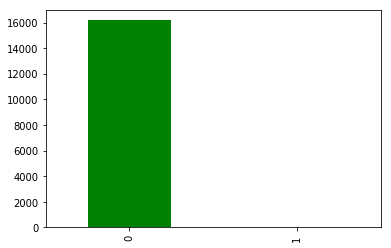

In [7]:
df_data_1.Label.value_counts().plot(kind = 'bar', color = 'green')

In [8]:
print(df_data_1.groupby('Label').size())

Label
0    16170
1       39
dtype: int64


We can see there are over sixteen thousands examples of no anomaly, and only 39 examples of anomalies. 

Let's examine the features in more detail. We will create box plots and histograms of each feature. These visualizations will help us better understand the range of values for each feature.

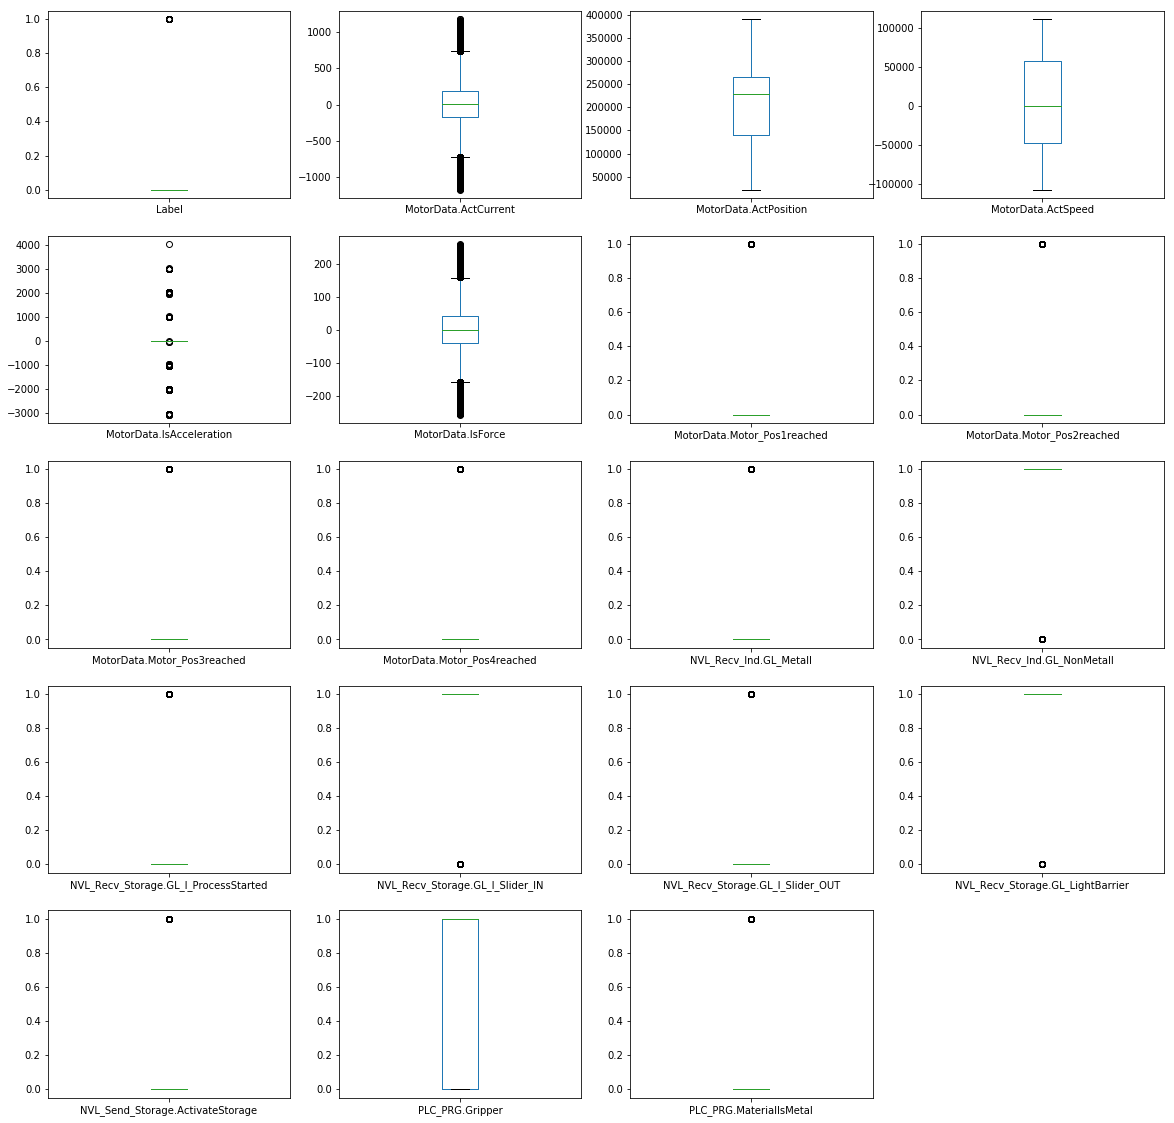

In [9]:
df_data_1.plot(kind='box', subplots=True, figsize=(20,20), layout=(5,4), sharex=False, sharey=False)
plt.show()

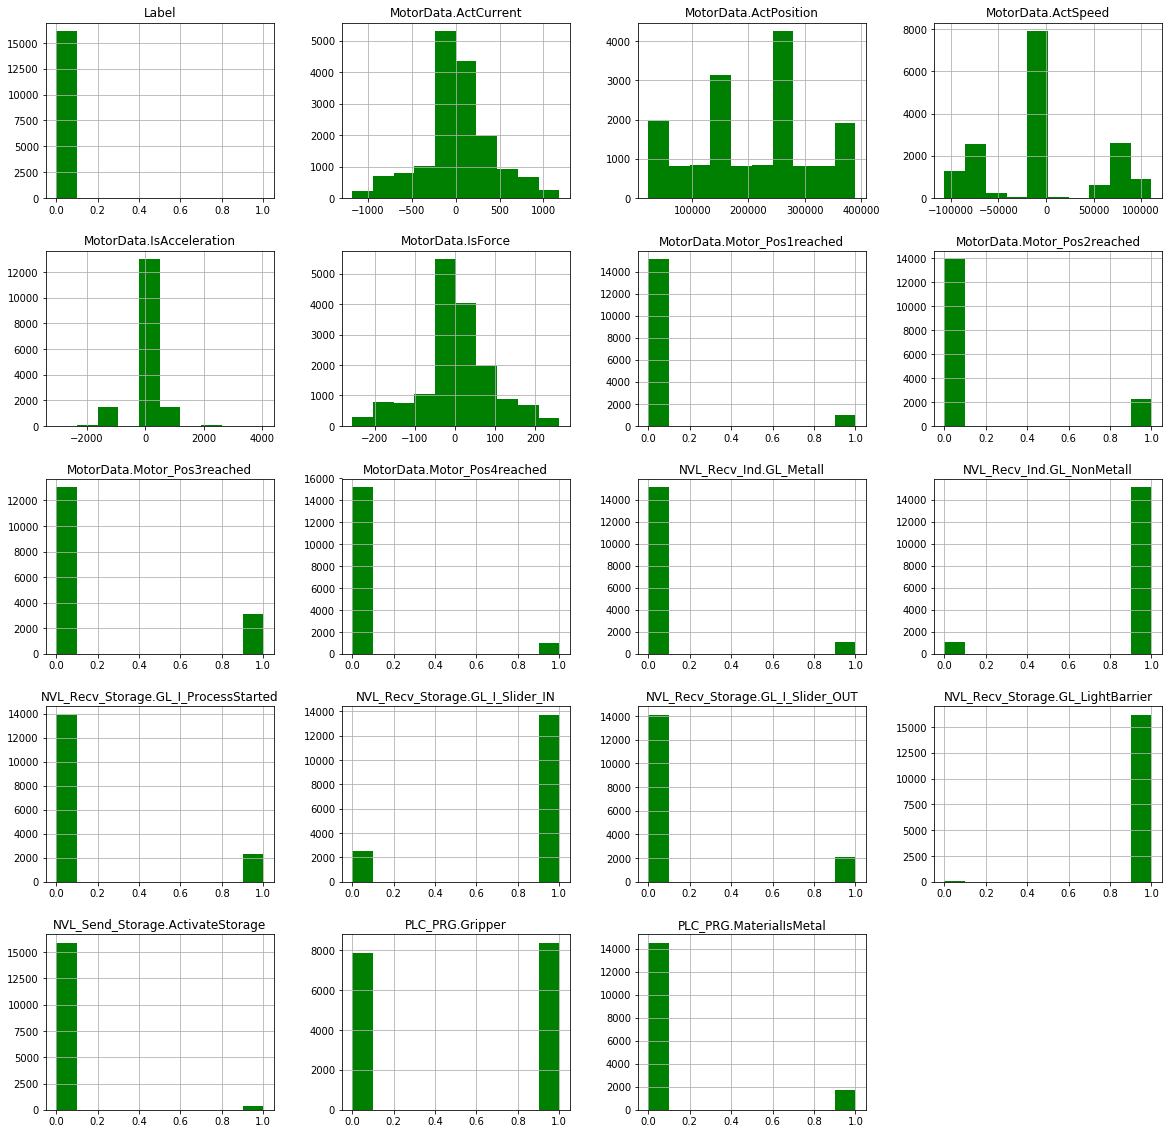

In [10]:
df_data_1.hist(figsize=(20,20), layout=(5,4), color = 'green')
plt.show()

Next, we'll plot a correlation matrix. A correlation matrix illustrates correlation coefficients between sets of features. Each feature in the matrix is correlated with each of the other features in the matrix. This enables us to see which pairs have the highest correlation.

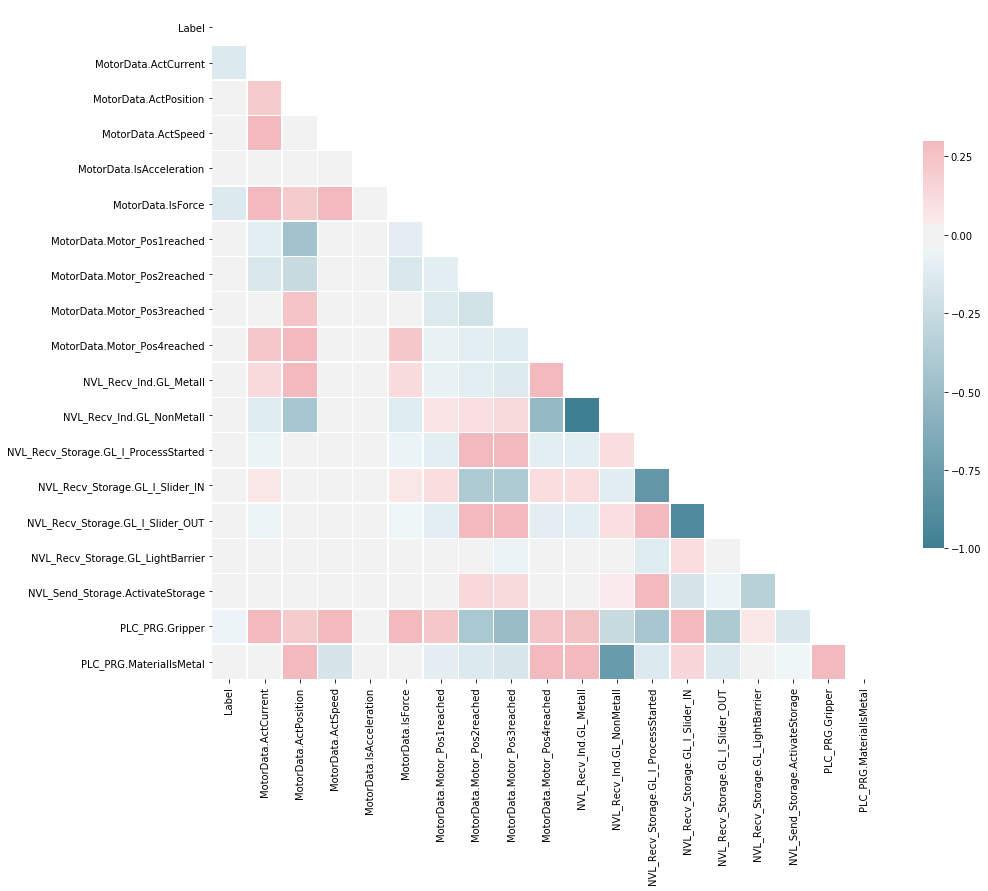

In [11]:
cov = df_data_1.corr()
fig = plt.figure(figsize = (15,15))

mask = np.zeros_like(cov, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(cov, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Data preparation

In the next section, we will prepare the data for our analysis. First, we'll see how the algorithms perform when we leave the class imbalance as is.

We begin by extracting 20% of the data set for our test set, which we will use later. We then normalize the data so that the feature values are in the same ranges. We will also split so that sets are stratified.

In [67]:
# Get validation dataset
array = df_data_1.values
X = df_data_1.drop('Label',axis=1)
Y = df_data_1.Label
# normalize the data attributes
scaler = MinMaxScaler(feature_range=(0, 1))
x_transformed = scaler.fit_transform(X)
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(x_transformed, Y, test_size=validation_size, random_state=seed, stratify=Y)


We can check to see the breakdown of class labels in both the training and test sets.

In [69]:
collections.Counter(Y_train)

Counter({0: 12936, 1: 31})

In [70]:
collections.Counter(Y_validation)

Counter({0: 3234, 1: 8})

Our measure of comparison will be 'F1'. F1 considers both the precision and the recall to compute the score: precision is the number of correct positive results divided by the number of all positive results returned by the classifier, and recall is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).

We will compare the performance against five different algorithms.

* Logistic Regression (LR)
* K-Nearest Neighbors (KNN).
* Decision Tree (Classification and Regression Trees) (CART).
* Gaussian Naive Bayes (NB).
* Support Vector Machines (SVM).

To ensure the results are comparable, the random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits.

In addition, we will visualize the results using box plots.

In [50]:
# Test options and evaluation metric
seed = 7
scoring = 'f1'

Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold. We use StratifiedKFold here. This type of cross-validation is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [71]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

In [74]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr',class_weight = 'balanced'))) # LR implicitly handles imbalance.
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	skf = StratifiedKFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=skf, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.814870 (0.118480)
KNN: 0.985714 (0.042857)
CART: 0.950000 (0.150000)
NB: 1.000000 (0.000000)


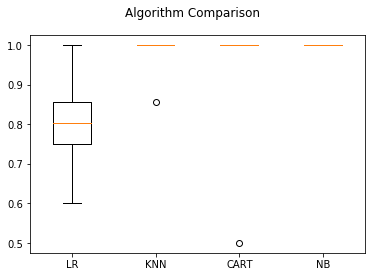

In [75]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

KNN performed second best. Let's see if we can adjust the parameters to improve the F1 performance. We will search for the optimal value for K by 

In [104]:
#search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []



# 1. we will loop through reasonable values of k
for k in k_range:
# 2. run KNeighborsClassifier with k neighbours
    knn.fit(X_train, Y_train)
    predictions = knn.predict(X_train)
    knn = KNeighborsClassifier(n_neighbors=k)
    precision_score(Y_train, predictions, pos_label=1, average='binary')
    recall_score(Y_train, predictions, pos_label=1, average='binary')
    scores = f1_score(Y_train, predictions, pos_label=1, average='binary')
    k_scores.append(scores.mean())
   
print(k_scores)

[0.98360655737704916, 1.0, 0.98360655737704916, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407]


Let's plot the trend line to find the optimal F1 score. We can see that the optimal value for k=2.

Text(0,0.5,'F1 score')

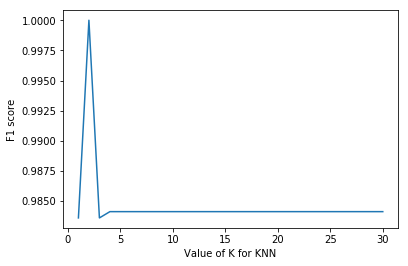

In [105]:

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score')

Let's run the test for K=3 and return some evaluation metrics for the positive label. We also introduce the Cohen's Kappa score, which is a metric often used with imbalanced data that compares an Observed Accuracy with an Expected Accuracy (random chance).

In [109]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_train)
kappa = cohen_kappa_score(Y_train, predictions)
matrix = confusion_matrix(Y_train, predictions)
print("Accuracy = ", accuracy_score(Y_train, predictions))
print('Cohens kappa: %f' % kappa)
print("Confusion Matrix = ")
print(confusion_matrix(Y_train, predictions))
print("Classification Report = ")
print(classification_report(Y_train, predictions))
print('Precision for positive label: ', precision_score(Y_train, predictions, pos_label=1, average='binary'))
print ('Recall for positive label: ', recall_score(Y_train, predictions, pos_label=1, average='binary'))
print ('F1 Score for positive label: ', f1_score(Y_train, predictions, pos_label=1, average='binary'))

Accuracy =  0.99992288116
Cohens kappa: 0.983568
Confusion Matrix = 
[[12936     0]
 [    1    30]]
Classification Report = 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12936
          1       1.00      0.97      0.98        31

avg / total       1.00      1.00      1.00     12967

Precision for positive label:  1.0
Recall for positive label:  0.967741935484
F1 Score for positive label:  0.983606557377


## Test on unseen data

So, let's test this model on unseen data.

In [110]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
kappa = cohen_kappa_score(Y_validation, predictions)
matrix = confusion_matrix(Y_validation, predictions)
print("Accuracy = ", accuracy_score(Y_validation, predictions))
print('Cohens kappa: %f' % kappa)
print("Confusion Matrix = ")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report = ")
print(classification_report(Y_validation, predictions))
print('Precision for positive label: ', precision_score(Y_validation, predictions, pos_label=1, average='binary'))
print ('Recall for positive label: ', recall_score(Y_validation, predictions, pos_label=1, average='binary'))
print ('F1 Score for positive label: ', f1_score(Y_validation, predictions, pos_label=1, average='binary'))

Accuracy =  0.999691548427
Cohens kappa: 0.933179
Confusion Matrix = 
[[3234    0]
 [   1    7]]
Classification Report = 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3234
          1       1.00      0.88      0.93         8

avg / total       1.00      1.00      1.00      3242

Precision for positive label:  1.0
Recall for positive label:  0.875
F1 Score for positive label:  0.933333333333


Ok, we can see the accuracy is incredibly good. However, the recall and f1 score for the postive class has dropped a little. Iss due to the imbalance in the classes when we were training the model? Let's employ a method to address the class imbalance issue.

## Oversampling

We will now employ a simple oversampling technique to address the class imbalance problem. Oversampling works by resampling the positive rows so that the resulting training set contains an equal number of positive and negative rows. Several techniques exist to oversample, but for this demonstration we will use the SMOTE algorithm. The SMOTE algorithm uses oversampling where synthetic rows are added which are similar to anomaly rows in row space.

To make the results generalizable, and to avoid information bleed, we only apply oversampling on the training data.

In [111]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, Y_train,
                                                  test_size=validation_size,
                                                  random_state=12, stratify=Y_train)

In [112]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

Let's check that we did this correctly by counting values in each data set.

In [113]:
# Count values for Y in training set
collections.Counter(y_train_res)

Counter({0: 10348, 1: 10348})

In [114]:
# Count values for Y in test set
collections.Counter(y_val)

Counter({0: 2588, 1: 6})

Now that we've applied the oversampling, let's run the new dataset through our models.

In [115]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr',class_weight = 'balanced' )))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, x_train_res, y_train_res, cv=skf, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.999710 (0.000320)
KNN: 0.999952 (0.000145)
CART: 1.000000 (0.000000)
NB: 1.000000 (0.000000)


Again, KNN performed quite well from an accuracy perspective. Let's evaluate how well it actually identified postive class labels (i.e. the anomalies).

In [116]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train_res, y_train_res)
predictions = knn.predict(x_train_res)
kappa = cohen_kappa_score(y_train_res, predictions)
matrix = confusion_matrix(y_train_res, predictions)
print("Accuracy = ", accuracy_score(y_train_res, predictions))
print('Cohens kappa: %f' % kappa)
print("Confusion Matrix = ")
print(confusion_matrix(y_train_res, predictions))
print("Classification Report = ")
print(classification_report(y_train_res, predictions))
print('Precision for positive label: ', precision_score(y_train_res, predictions, pos_label=1, average='binary'))
print ('Recall for positive label: ', recall_score(y_train_res, predictions, pos_label=1, average='binary'))
print ('F1 Score for positive label: ', f1_score(y_train_res, predictions, pos_label=1, average='binary'))

Accuracy =  1.0
Cohens kappa: 1.000000
Confusion Matrix = 
[[10348     0]
 [    0 10348]]
Classification Report = 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10348
          1       1.00      1.00      1.00     10348

avg / total       1.00      1.00      1.00     20696

Precision for positive label:  1.0
Recall for positive label:  1.0
F1 Score for positive label:  1.0


We can see that it performed incredibly well on the training data! Let's put it to the test on unseen data.

## Test on unseen data

In [117]:
#Make predictions
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train_res, y_train_res)
predictions = knn.predict(X_validation)
kappa = cohen_kappa_score(Y_validation, predictions)
matrix = confusion_matrix(Y_validation, predictions)
print("Accuracy = ", accuracy_score(Y_validation, predictions))
print('Cohens kappa: %f' % kappa)
print("Confusion Matrix = ")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report = ")
print(classification_report(Y_validation, predictions))
print('Precision for positive label: ', precision_score(Y_validation, predictions, pos_label=1, average='binary'))
print ('Recall for positive label: ', recall_score(Y_validation, predictions, pos_label=1, average='binary'))
print ('F1 Score for positive label: ', f1_score(Y_validation, predictions, pos_label=1, average='binary'))

Accuracy =  1.0
Cohens kappa: 1.000000
Confusion Matrix = 
[[3234    0]
 [   0    8]]
Classification Report = 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3234
          1       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00      3242

Precision for positive label:  1.0
Recall for positive label:  1.0
F1 Score for positive label:  1.0


# Conclusion

Wow, we can see that this performed incredibly well on unseen data too. 

Hopefully, this notebook has give you a sense of the various steps one might take in a modelling excercise. Finding the best fit for the problem you are trying to solve is iterative and experimental.

Now that you have found a good model for this type of anomaly detection, think about how you might use this in a production setting with Maximo Predictive Maintenance Insights (PMI). For example, in addition to viewing it in Maximo PMI, you might also want to create some automation scripts to trigger service requests or even work orders when an anomaly is detected. 